In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# load pop
df = gpd.read_file('../../public/data/mapMain/jaipur_eai.geojson')
df = df[['hex_id','geometry','pop_sum']]
df.head()

,hex_id,geometry,pop_sum
0,23,"POLYGON ((75.6882 26.92514, 75.68966 26.92739,...",101
1,24,"POLYGON ((75.68817 26.92063, 75.68964 26.92288...",344
2,25,"POLYGON ((75.68814 26.91612, 75.68961 26.91837...",46
3,26,"POLYGON ((75.68811 26.9116, 75.68958 26.91385,...",99
4,27,"POLYGON ((75.68809 26.90709, 75.68955 26.90934...",128


In [16]:
# load ward
df_ward = gpd.read_file('../../public/data/mapMain/jaipur_wards.geojson')
df_ward.head()

,ward_id,jmc,jmc_name,ward_no,assembly,color_assembly,pop,dens_pph,geometry
0,G-1,150,Greater,1,VIDHYADHAR NAGAR,#abd0ac,11930,24,"POLYGON ((75.74601 27.00898, 75.73282 27.02027..."
1,G-2,150,Greater,2,VIDHYADHAR NAGAR,#abd0ac,11096,23,"POLYGON ((75.74601 27.00898, 75.75914 27.00912..."
2,G-3,150,Greater,3,VIDHYADHAR NAGAR,#abd0ac,12110,81,"POLYGON ((75.75914 27.00912, 75.76543 27.0173,..."
3,G-4,150,Greater,4,VIDHYADHAR NAGAR,#abd0ac,12097,78,"POLYGON ((75.77059 26.99986, 75.77021 27.00214..."
4,G-5,150,Greater,5,VIDHYADHAR NAGAR,#abd0ac,12158,27,"POLYGON ((75.77957 27.00536, 75.77965 27.00599..."


In [17]:
#load bus and metro stops
bus_stops = gpd.read_file('../../public/data/mapMain/bus_stops.geojson')
metro_stations = gpd.read_file('../../public/data/mapMain/metro_stations.geojson')

In [18]:
# Projected crs
bus_stops.to_crs('EPSG:7774', inplace=True)
metro_stations.to_crs('EPSG:7774', inplace=True)
df.to_crs('EPSG:7774', inplace=True)
df_ward.to_crs('EPSG:7774', inplace=True)

In [19]:
# Buffer 500m around bus stops and metro stations
bus_buffer = bus_stops.buffer(500)
metro_buffer = metro_stations.buffer(500)

In [20]:
# create a column is_accessible, True if within 500m of bus or metro station
all_transit_geometries = pd.concat(
    [bus_buffer.geometry, metro_buffer.geometry])
accessible_area = all_transit_geometries.union_all()

df['is_accessible'] = df['geometry'].intersects(accessible_area)
df.head()

,hex_id,geometry,pop_sum,is_accessible
0,23,"POLYGON ((1179899.526 1005724.617, 1180041.545...",101,False
1,24,"POLYGON ((1179903.959 1005224.971, 1180045.977...",344,False
2,25,"POLYGON ((1179908.392 1004725.325, 1180050.411...",46,False
3,26,"POLYGON ((1179912.825 1004225.679, 1180054.844...",99,False
4,27,"POLYGON ((1179917.26 1003726.033, 1180059.278 ...",128,False


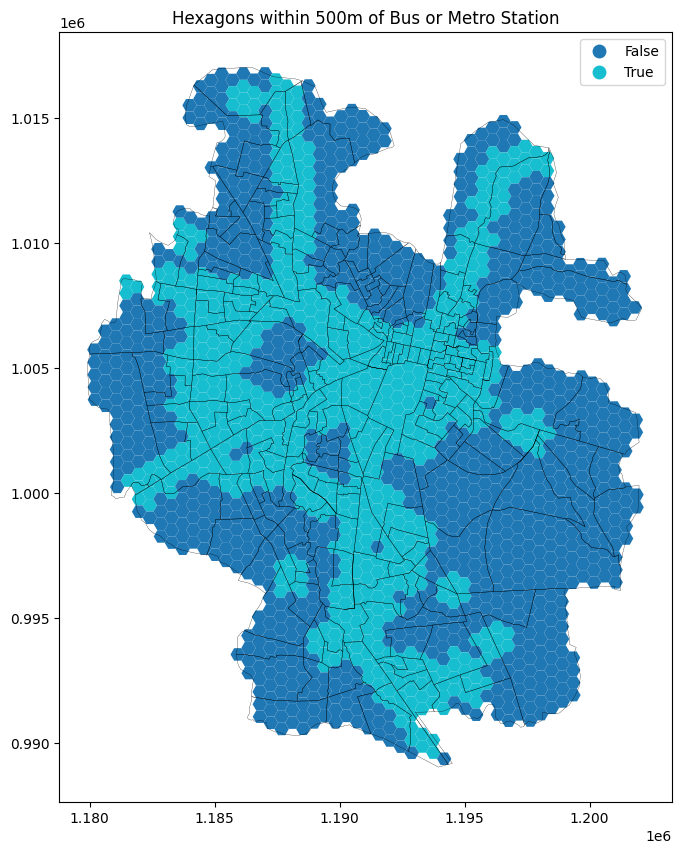

In [21]:
# map hex true
fig,ax = plt.subplots(1,1,figsize=(10,10))
df.plot(column='is_accessible', ax=ax, legend=True)
df_ward.boundary.plot(ax=ax, color='black', linewidth=0.2)
ax.set_title('Hexagons within 500m of Bus or Metro Station')
plt.show()

In [22]:
# intersect ward with hex, sum pop where is_accessible is True
ward_accessible_pop = gpd.sjoin(df[df['is_accessible'] == True], df_ward, how='inner', predicate='intersects')
ward_accessible_pop = ward_accessible_pop.groupby('ward_id')['pop_sum'].sum().reset_index()
ward_accessible_pop.columns = ['ward_id', 'accessible_pop_sum']

ward_total_pop = gpd.sjoin(df, df_ward, how='inner', predicate='intersects')
ward_total_pop = ward_total_pop.groupby('ward_id')['pop_sum'].sum().reset_index()
ward_total_pop.columns = ['ward_id', 'pop_sum']

df_ward = df_ward.merge(ward_accessible_pop[['ward_id', 'accessible_pop_sum']], on='ward_id', how='left')
df_ward = df_ward.merge(ward_total_pop[['ward_id', 'pop_sum']], on='ward_id', how='left')
df_ward['pct_accessible'] = round(df_ward['accessible_pop_sum'] / df_ward['pop_sum'] * 100,2)

# fillna for accessible_pop_sum and pct_accessible with 
df_ward['accessible_pop_sum'] = df_ward['accessible_pop_sum'].fillna(0)
df_ward['pct_accessible'] = df_ward['pct_accessible'].fillna(0)
df_ward.head()

,ward_id,jmc,jmc_name,ward_no,assembly,color_assembly,pop,dens_pph,geometry,accessible_pop_sum,pop_sum,pct_accessible
0,G-1,150,Greater,1,VIDHYADHAR NAGAR,#abd0ac,11930,24,"POLYGON ((1185498.275 1015087.032, 1184172.14 ...",8523.0,13435,63.44
1,G-2,150,Greater,2,VIDHYADHAR NAGAR,#abd0ac,11096,23,"POLYGON ((1185498.275 1015087.032, 1186799.107...",5261.0,22425,23.46
2,G-3,150,Greater,3,VIDHYADHAR NAGAR,#abd0ac,12110,81,"POLYGON ((1186799.107 1015121.483, 1187409.09 ...",20331.0,22935,88.65
3,G-4,150,Greater,4,VIDHYADHAR NAGAR,#abd0ac,12097,78,"POLYGON ((1187950.177 1014113.442, 1187908.65 ...",15703.0,19409,80.91
4,G-5,150,Greater,5,VIDHYADHAR NAGAR,#abd0ac,12158,27,"POLYGON ((1188830.781 1014735.383, 1188837.696...",185.0,15888,1.16


In [23]:
df_ward['accessible_pop_sum'].sum(), df_ward['pop_sum'].sum(), df_ward['accessible_pop_sum'].sum() / df_ward['pop_sum'].sum() * 100

(np.float64(5728503.0), np.int64(8792918), np.float64(65.14905518281871))

In [24]:
df_ward.shape

(251, 12)

In [25]:
#save as A02.geojson
df_ward.to_crs('EPSG:4326', inplace=True)
df_ward.to_file('../../public/data/kpiMaps/A02.geojson', driver='GeoJSON')

In [27]:
df_ward.isna().sum()

ward_id               0
jmc                   0
jmc_name              0
ward_no               0
assembly              0
color_assembly        0
pop                   0
dens_pph              0
geometry              0
accessible_pop_sum    0
pop_sum               0
pct_accessible        0
dtype: int64